In [1]:
import pandas as pd

base_dir = '/kaggle/input/skin-cancer-mnist-ham10000/'
train_df = pd.read_csv(base_dir + 'HAM10000_metadata.csv')
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [2]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import os
from keras import layers
from keras.models import Sequential
from keras.layers import Dense ,Conv2D, MaxPooling2D, Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import AlphaDropout
from keras.layers import GaussianNoise
from keras.layers import Add, AveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras import losses
from keras import Model
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import zoom
from tensorflow.keras import activations
from keras.callbacks import ReduceLROnPlateau

In [3]:
from keras.losses import CategoricalCrossentropy

laloss = CategoricalCrossentropy(label_smoothing=0.6)

In [4]:
train_df = pd.read_csv(base_dir + 'HAM10000_metadata.csv')
train_df.drop(["lesion_id"],axis = 1)
train_df.drop(["dx_type"],axis = 1)

from sklearn.preprocessing import OneHotEncoder
encDX = OneHotEncoder(handle_unknown='ignore')
y_categorical = encDX.fit_transform(np.array(train_df["dx"]).reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(train_df, y_categorical, test_size = 0.1, random_state = 42, shuffle = True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2.0/9.0, random_state = 42, shuffle = True)


del train_df

x_trainImg = np.zeros((7010,45,60,3),dtype = np.uint8)
x_valImg = np.zeros((2003,45,60,3),dtype = np.uint8)
x_testImg = np.zeros((1002,45,60,3),dtype = np.uint8)

a = 0

for i in x_train["image_id"].values:
    if i + '.jpg' in os.listdir(base_dir + 'HAM10000_images_part_2/'):
        x_trainImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_2/' + i + '.jpg'),[0.1,0.1,1]))
    else:
        x_trainImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_1/' + i + '.jpg'),[0.1,0.1,1]))
    a+=1
    if a%1000 == 0:
        print(a/1000)

a = 0        
        
for i in x_val["image_id"].values:
    if i + '.jpg' in os.listdir(base_dir + 'HAM10000_images_part_2/'):
        x_valImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_2/' + i + '.jpg'),[0.1,0.1,1]))
    else:
        x_valImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_1/' + i + '.jpg'),[0.1,0.1,1]))
    a+=1
    if a%1000 == 0:
        print(a/1000)

a = 0 

for i in x_test["image_id"].values:
    if i + '.jpg' in os.listdir(base_dir + 'HAM10000_images_part_2/'):
        x_testImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_2/' + i + '.jpg'),[0.1,0.1,1]))
    else:
        x_testImg[a,] = np.array(zoom(imread(base_dir + 'HAM10000_images_part_1/' + i + '.jpg'),[0.1,0.1,1]))
    a+=1
    if a%1000 == 0:
        print(a/1000)


media = np.mean(x_trainImg)
desvio = np.std(x_trainImg)

x_trainImg = (x_trainImg - media)/desvio
x_valImg = (x_valImg - media)/desvio
x_testImg = (x_testImg - media)/desvio

x_trainAge = x_train["age"]

media = np.mean(x_trainAge)
desvio = np.std(x_trainAge)

x_trainAge = (x_trainAge - media)/desvio
x_valAge = (x_val["age"] - media)/desvio
x_testAge = (x_test["age"] - media)/desvio

encGen = OneHotEncoder(handle_unknown='ignore')
x_trainGen = encGen.fit_transform(np.array(x_train["sex"].tolist()).reshape(-1, 1))
x_valGen = encGen.transform(np.array(x_val["sex"].tolist()).reshape(-1, 1))
x_testGen = encGen.transform(np.array(x_test["sex"].tolist()).reshape(-1, 1))

encLoc = OneHotEncoder(handle_unknown='ignore')
x_trainLoc = encLoc.fit_transform(np.array(x_train["localization"].tolist()).reshape(-1, 1))
x_valLoc = encLoc.transform(np.array(x_val["localization"].tolist()).reshape(-1, 1))
x_testLoc = encLoc.transform(np.array(x_test["localization"].tolist()).reshape(-1, 1))

1.0
2.0
3.0
4.0
5.0
6.0
7.0
1.0
2.0
1.0


In [51]:
datagen = ImageDataGenerator(
                            rotation_range=10, 
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            zoom_range=0.1,
                            )

datagen.fit(np.array(x_trainImg))

# Con el mejor modelo obtenido para AlexNET:

In [54]:
imagen = layers.Input((45, 60, 3),name='image_input')
metadatosAge = layers.Input((1,),name = 'meta_age')
metadatosLoc = layers.Input((15,),name = 'meta_loc')
metadatosSex = layers.Input((3,),name = 'meta_sex')

################################## TIPO ALEXNET #####################################################################
net = Conv2D(filters=4, kernel_size=(11, 11),strides = 4, padding='same')(imagen)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), padding='same')(net)

net = Conv2D(filters=8, kernel_size=(5, 5),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Conv2D(filters=32, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=32, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = Conv2D(filters=16, kernel_size=(3, 3),strides = 1, padding='same')(net)
net = Activation(activations.relu)(net)
net = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(net)

net = Flatten()(net)

net = Dense(units=256, activation='relu')(net)
net = Dropout(0.1)(net)
net = Dense(units=128, activation='relu')(net)
net = Dropout(0.1)(net)
#######################################################################################################################



######################################### ENTRADA DE METADATOS ########################################################
metaConcat = layers.Concatenate()([metadatosAge, metadatosLoc, metadatosSex])
metadata1 = Dense(2,activation='relu')(metaConcat)
metadata2 = Dense(4,activation='relu')(metadata1)
metadata3 = Dense(16,activation='relu')(metadata2)
########################################################################################################################

junta= layers.Concatenate()([net, metadata3])

denseFinal = Dense(128,activation='relu')(junta)
lastdrop = Dropout(0.1)(denseFinal)

outN = Dense(units=7, activation = 'softmax')(lastdrop)

model = Model(inputs=[imagen, metadatosAge, metadatosLoc, metadatosSex], outputs=outN)

model.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 12, 15, 4)    1456        image_input[0][0]                
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 12, 15, 4)    0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 4, 5, 4)      0           activation_20[0][0]              
____________________________________________________________________________________________

In [55]:
dataaugm = datagen.flow(np.array(x_trainImg),y_train.toarray(),batch_size = 7010).next()

hist = model.fit({'image_input':dataaugm[0],'meta_age':np.array(x_trainAge.tolist()),
           'meta_loc':x_trainLoc.toarray(),'meta_sex':x_trainGen.toarray()},
          dataaugm[1], batch_size=2,validation_data = ({'image_input':np.array(x_valImg),'meta_age':np.array(x_valAge.tolist()),
           'meta_loc':x_valLoc.toarray(),'meta_sex':x_valGen.toarray()},y_val.toarray()), epochs=50, shuffle=True,
        callbacks = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=0.00001))

Epoch 1/50
3505/3505 [==============================] - 17s 5ms/step - loss: 1.7839 - accuracy: 0.6755 - val_loss: 1.7835 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 2/50
3505/3505 [==============================] - 17s 5ms/step - loss: 1.7732 - accuracy: 0.6812 - val_loss: 1.7761 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 3/50
3505/3505 [==============================] - 18s 5ms/step - loss: 1.7684 - accuracy: 0.6820 - val_loss: 1.7703 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 4/50
3505/3505 [==============================] - 17s 5ms/step - loss: 1.7657 - accuracy: 0.6842 - val_loss: 1.7770 - val_accuracy: 0.6161 - lr: 0.0010
Epoch 5/50
3505/3505 [==============================] - 17s 5ms/step - loss: 1.7638 - accuracy: 0.6912 - val_loss: 1.7606 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 6/50
3505/3505 [==============================] - 17s 5ms/step - loss: 1.7631 - accuracy: 0.6969 - val_loss: 1.7671 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 7/50
3505/3505 [==============================

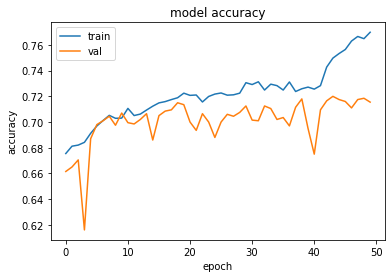

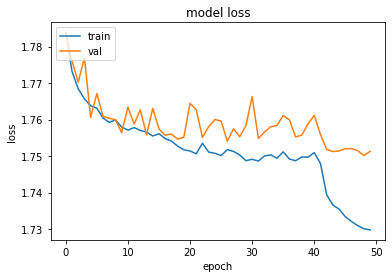

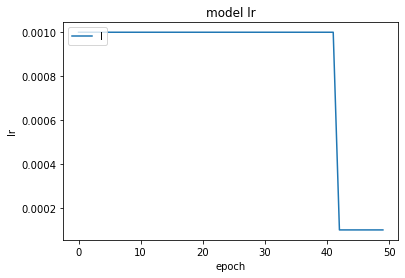

In [56]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(hist.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

# Con el mejor modelo obtenido de ResNET

In [57]:
def res_block_first(input_layer,filters=4):
    
    #Primera capa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(aux_net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    
    #Shortcut
    net=Add()([aux_net,net])
    
    net=Activation("relu")(net)
    net=MaxPooling2D()(net)
    
    return net

def res_block(input_layer,filters=16, kern = 3):
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net = Dropout(0.2)(net)
    
    #Shortcut
    net=Add()([input_layer,net])
    net=Activation("relu")(net)
    
    return net

def res_block_dec(input_layer,filters=32, kern = 3):
    
    input_layer=MaxPooling2D()(input_layer)
    net=Conv2D(filters=filters, kernel_size=(1, 1), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(kern, kern), padding='same')(net)
    net=BatchNormalization()(net)
    net=Add()([aux_net,net])
    net=Activation("relu")(net)
    
    return net

In [58]:
imagen = layers.Input((45, 60, 3),name='image_input')
metadatosAge = layers.Input((1,),name = 'meta_age')
metadatosLoc = layers.Input((15,),name = 'meta_loc')
metadatosSex = layers.Input((3,),name = 'meta_sex')

################################## TIPO ALEXNET #####################################################################
net=res_block_first(imagen,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block(net,filters=2)
net=res_block_dec(net,filters=8)
net=res_block(net,filters=8, kern = 10)
net=res_block(net,filters=8, kern = 10)
net=res_block(net,filters=8, kern = 10)
net=res_block_dec(net,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)

net = AveragePooling2D() (net)

net=Flatten()(net)

net=Dense(units=128, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=128, activation='relu')(net)
net=Dropout(0.1)(net)
#######################################################################################################################



######################################### ENTRADA DE METADATOS ########################################################
metaConcat = layers.Concatenate()([metadatosAge, metadatosLoc, metadatosSex])
metadata1 = Dense(2,activation='relu')(metaConcat)
metadata2 = Dense(4,activation='relu')(metadata1)
metadata3 = Dense(16,activation='relu')(metadata2)
########################################################################################################################

junta= layers.Concatenate()([net, metadata3])

denseFinal = Dense(128,activation='relu')(junta)
lastdrop = Dropout(0.1)(denseFinal)

outN = Dense(units=7, activation = 'softmax')(lastdrop)

modelR = Model(inputs=[imagen, metadatosAge, metadatosLoc, metadatosSex], outputs=outN)

modelR.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])
modelR.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 45, 60, 2)    56          image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 45, 60, 2)    8           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 45, 60, 2)    38          batch_normalization[0][0]        
____________________________________________________________________________________________

In [59]:
dataaugm = datagen.flow(np.array(x_trainImg),y_train.toarray(),batch_size = 7010).next()

histR = modelR.fit({'image_input':dataaugm[0],'meta_age':np.array(x_trainAge.tolist()),
           'meta_loc':x_trainLoc.toarray(),'meta_sex':x_trainGen.toarray()},
          dataaugm[1], batch_size=2,validation_data = ({'image_input':np.array(x_valImg),'meta_age':np.array(x_valAge.tolist()),
           'meta_loc':x_valLoc.toarray(),'meta_sex':x_valGen.toarray()},y_val.toarray()), epochs=50, shuffle=True,
        callbacks = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=0.00001))

Epoch 1/50
3505/3505 [==============================] - 59s 17ms/step - loss: 1.7977 - accuracy: 0.6728 - val_loss: 1.8053 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 2/50
3505/3505 [==============================] - 59s 17ms/step - loss: 1.7853 - accuracy: 0.6745 - val_loss: 1.7832 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 3/50
3505/3505 [==============================] - 58s 17ms/step - loss: 1.7811 - accuracy: 0.6753 - val_loss: 1.7894 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 4/50
3505/3505 [==============================] - 58s 17ms/step - loss: 1.7776 - accuracy: 0.6732 - val_loss: 1.7963 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 5/50
3505/3505 [==============================] - 59s 17ms/step - loss: 1.7744 - accuracy: 0.6720 - val_loss: 1.7846 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 6/50
3505/3505 [==============================] - 58s 17ms/step - loss: 1.7714 - accuracy: 0.6809 - val_loss: 1.7654 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 7/50
3505/3505 [========================

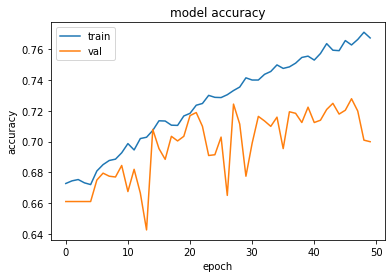

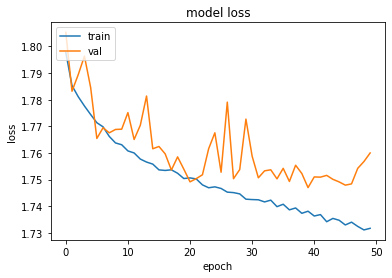

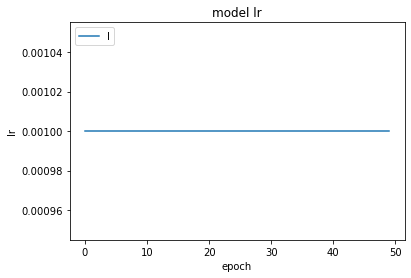

In [60]:
# summarize history for accuracy
plt.plot(histR.history['accuracy'])
plt.plot(histR.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histR.history['loss'])
plt.plot(histR.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histR.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

# Con el mejor modelo de Inception

In [61]:
def inception_block(input_layer,filters=64):
    tower_1 = Conv2D(filters, (1,1), padding='same', activation='relu')(input_layer)
    tower_1 = Conv2D(filters, (3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(filters, (1,1), padding='same', activation='relu')(input_layer)
    tower_2 = Conv2D(filters, (5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    tower_3 = Conv2D(filters, (1,1), padding='same', activation='relu')(tower_3)
    output = layers.Concatenate()([tower_1, tower_2, tower_3])
    return output

In [62]:
imagen = layers.Input((45, 60, 3),name='image_input')
metadatosAge = layers.Input((1,),name = 'meta_age')
metadatosLoc = layers.Input((15,),name = 'meta_loc')
metadatosSex = layers.Input((3,),name = 'meta_sex')

################################## TIPO ALEXNET #####################################################################
net = Conv2D(4, kernel_size = (7,7), strides = 2)(imagen)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)
net = Conv2D(8, kernel_size = (3,3), strides = 1)(net)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,16)
net = inception_block(net,16)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,32)
net = inception_block(net,32)
net = inception_block(net,32)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = AveragePooling2D(pool_size = (1,2), strides = 1)(net)
net = Flatten()(net)
net = Dense(64, activation = 'relu')(net)
net = Dropout(0.3)(net)
#######################################################################################################################



######################################### ENTRADA DE METADATOS ########################################################
metaConcat = layers.Concatenate()([metadatosAge, metadatosLoc, metadatosSex])
metadata1 = Dense(2,activation='relu')(metaConcat)
metadata2 = Dense(4,activation='relu')(metadata1)
metadata3 = Dense(16,activation='relu')(metadata2)
########################################################################################################################

junta= layers.Concatenate()([net, metadata3])

denseFinal = Dense(128,activation='relu')(junta)
lastdrop = Dropout(0.1)(denseFinal)

outN = Dense(units=7, activation = 'softmax')(lastdrop)

modelInc = Model(inputs=[imagen, metadatosAge, metadatosLoc, metadatosSex], outputs=outN)

modelInc.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])
modelInc.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 20, 27, 4)    592         image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 10, 14, 4)    0           conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 8, 12, 8)     296         max_pooling2d_18[0][0]           
____________________________________________________________________________________________

In [64]:
dataaugm = datagen.flow(np.array(x_trainImg),y_train.toarray(),batch_size = 7010).next()

histInc = modelInc.fit({'image_input':dataaugm[0],'meta_age':np.array(x_trainAge.tolist()),
           'meta_loc':x_trainLoc.toarray(),'meta_sex':x_trainGen.toarray()},
          dataaugm[1], batch_size=4,validation_data = ({'image_input':np.array(x_valImg),'meta_age':np.array(x_valAge.tolist()),
           'meta_loc':x_valLoc.toarray(),'meta_sex':x_valGen.toarray()},y_val.toarray()), epochs=50, shuffle=True,
        callbacks = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=0.00001))

Epoch 1/50
1753/1753 [==============================] - 18s 11ms/step - loss: 1.7795 - accuracy: 0.6786 - val_loss: 1.7670 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 2/50
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7684 - accuracy: 0.6902 - val_loss: 1.7620 - val_accuracy: 0.6795 - lr: 0.0010
Epoch 3/50
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7636 - accuracy: 0.6996 - val_loss: 1.7614 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 4/50
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7583 - accuracy: 0.7057 - val_loss: 1.7573 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 5/50
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7562 - accuracy: 0.7080 - val_loss: 1.7575 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 6/50
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7549 - accuracy: 0.7153 - val_loss: 1.7566 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 7/50
1753/1753 [========================

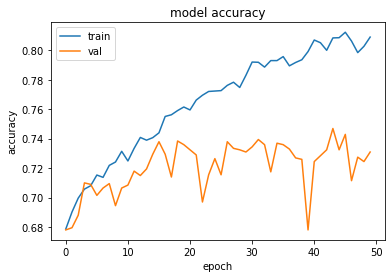

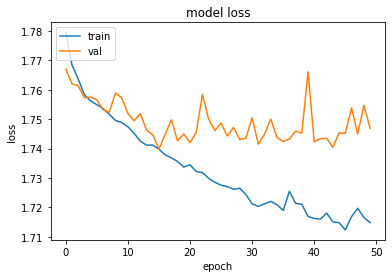

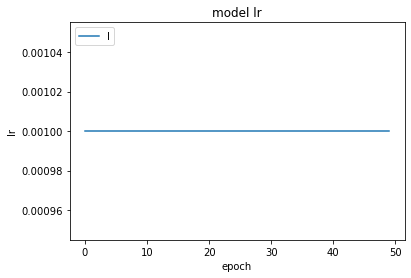

In [65]:
# summarize history for accuracy
plt.plot(histInc.history['accuracy'])
plt.plot(histInc.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histInc.history['loss'])
plt.plot(histInc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histInc.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

# Probamos el mejor modelo sin Data Augmentation

In [69]:
imagen = layers.Input((45, 60, 3),name='image_input')
metadatosAge = layers.Input((1,),name = 'meta_age')
metadatosLoc = layers.Input((15,),name = 'meta_loc')
metadatosSex = layers.Input((3,),name = 'meta_sex')

################################## TIPO ALEXNET #####################################################################
net = Conv2D(4, kernel_size = (7,7), strides = 2)(imagen)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)
net = Conv2D(8, kernel_size = (3,3), strides = 1)(net)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,16)
net = inception_block(net,16)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,32)
net = inception_block(net,32)
net = inception_block(net,32)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = AveragePooling2D(pool_size = (1,2), strides = 1)(net)
net = Flatten()(net)
net = Dense(64, activation = 'relu')(net)
net = Dropout(0.3)(net)
#######################################################################################################################



######################################### ENTRADA DE METADATOS ########################################################
metaConcat = layers.Concatenate()([metadatosAge, metadatosLoc, metadatosSex])
metadata1 = Dense(2,activation='relu')(metaConcat)
metadata2 = Dense(4,activation='relu')(metadata1)
metadata3 = Dense(16,activation='relu')(metadata2)
########################################################################################################################

junta= layers.Concatenate()([net, metadata3])

denseFinal = Dense(128,activation='relu')(junta)
lastdrop = Dropout(0.1)(denseFinal)

outN = Dense(units=7, activation = 'softmax')(lastdrop)

modelR1 = Model(inputs=[imagen, metadatosAge, metadatosLoc, metadatosSex], outputs=outN)

modelR1.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])
modelR1.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 20, 27, 4)    592         image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 10, 14, 4)    0           conv2d_157[0][0]                 
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 8, 12, 8)     296         max_pooling2d_39[0][0]           
____________________________________________________________________________________________

In [70]:
histR1 = modelR1.fit({'image_input':np.array(x_trainImg),'meta_age':np.array(x_trainAge.tolist()),
           'meta_loc':x_trainLoc.toarray(),'meta_sex':x_trainGen.toarray()},
          y_train.toarray(), batch_size=4,validation_data = ({'image_input':np.array(x_valImg),'meta_age':np.array(x_valAge.tolist()),
           'meta_loc':x_valLoc.toarray(),'meta_sex':x_valGen.toarray()},y_val.toarray()), epochs=50, shuffle=True,
        callbacks = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=0.00001))

Epoch 1/50
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7793 - accuracy: 0.6833 - val_loss: 1.7663 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 2/50
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7686 - accuracy: 0.6920 - val_loss: 1.7630 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 3/50
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7616 - accuracy: 0.6984 - val_loss: 1.7577 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 4/50
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7597 - accuracy: 0.7017 - val_loss: 1.7562 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 5/50
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7549 - accuracy: 0.7097 - val_loss: 1.7544 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 6/50
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7538 - accuracy: 0.7188 - val_loss: 1.7575 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 7/50
1753/1753 [========================

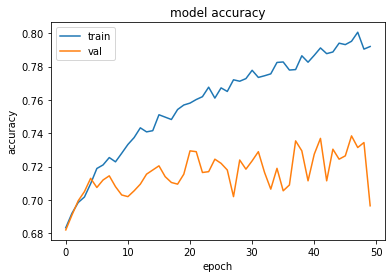

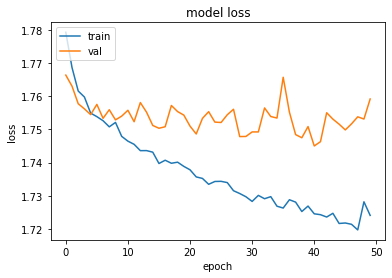

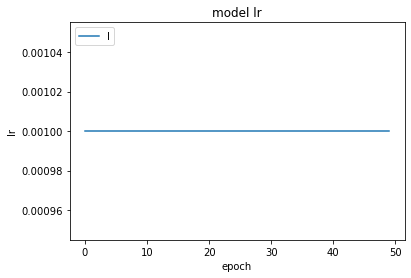

In [71]:
# summarize history for accuracy
plt.plot(histR1.history['accuracy'])
plt.plot(histR1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histR1.history['loss'])
plt.plot(histR1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for lr
plt.plot(histR1.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend('lr', loc='upper left')
plt.show()

# Evaluamos en test el mejor modelo

In [78]:
imagen = layers.Input((45, 60, 3),name='image_input')
metadatosAge = layers.Input((1,),name = 'meta_age')
metadatosLoc = layers.Input((15,),name = 'meta_loc')
metadatosSex = layers.Input((3,),name = 'meta_sex')

################################## TIPO ALEXNET #####################################################################
net = Conv2D(4, kernel_size = (7,7), strides = 2)(imagen)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)
net = Conv2D(8, kernel_size = (3,3), strides = 1)(net)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,16)
net = inception_block(net,16)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = inception_block(net,32)
net = inception_block(net,32)
net = inception_block(net,32)
net = MaxPooling2D((3,3), strides=2, padding='same')(net)

net = AveragePooling2D(pool_size = (1,2), strides = 1)(net)
net = Flatten()(net)
net = Dense(64, activation = 'relu')(net)
net = Dropout(0.3)(net)
#######################################################################################################################



######################################### ENTRADA DE METADATOS ########################################################
metaConcat = layers.Concatenate()([metadatosAge, metadatosLoc, metadatosSex])
metadata1 = Dense(2,activation='relu')(metaConcat)
metadata2 = Dense(4,activation='relu')(metadata1)
metadata3 = Dense(16,activation='relu')(metadata2)
########################################################################################################################

junta= layers.Concatenate()([net, metadata3])

denseFinal = Dense(128,activation='relu')(junta)
lastdrop = Dropout(0.1)(denseFinal)

outN = Dense(units=7, activation = 'softmax')(lastdrop)

modelInc = Model(inputs=[imagen, metadatosAge, metadatosLoc, metadatosSex], outputs=outN)

modelInc.compile(loss=laloss, optimizer='Adam', metrics=['accuracy'])
modelInc.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 45, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 20, 27, 4)    592         image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 10, 14, 4)    0           conv2d_184[0][0]                 
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 8, 12, 8)     296         max_pooling2d_48[0][0]           
___________________________________________________________________________________________

In [79]:
dataaugm = datagen.flow(np.array(x_trainImg),y_train.toarray(),batch_size = 7010).next()

histInc = modelInc.fit({'image_input':dataaugm[0],'meta_age':np.array(x_trainAge.tolist()),
           'meta_loc':x_trainLoc.toarray(),'meta_sex':x_trainGen.toarray()},
          dataaugm[1], batch_size=4,validation_data = ({'image_input':np.array(x_valImg),'meta_age':np.array(x_valAge.tolist()),
           'meta_loc':x_valLoc.toarray(),'meta_sex':x_valGen.toarray()},y_val.toarray()), epochs=6, shuffle=True,
        callbacks = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=0.00001))

Epoch 1/44
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7820 - accuracy: 0.6760 - val_loss: 1.7765 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 2/44
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7677 - accuracy: 0.6909 - val_loss: 1.7668 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 3/44
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7642 - accuracy: 0.6927 - val_loss: 1.7629 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 4/44
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7616 - accuracy: 0.6987 - val_loss: 1.7606 - val_accuracy: 0.6885 - lr: 0.0010
Epoch 5/44
1753/1753 [==============================] - 18s 10ms/step - loss: 1.7571 - accuracy: 0.6983 - val_loss: 1.7596 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 6/44
1753/1753 [==============================] - 19s 11ms/step - loss: 1.7579 - accuracy: 0.7001 - val_loss: 1.7732 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 7/44
1753/1753 [========================

In [80]:
modelInc.evaluate({'image_input':x_testImg,'meta_age':np.array(x_testAge.tolist()),
           'meta_loc':x_testLoc.toarray(),'meta_sex':x_testGen.toarray()},y_test.toarray())

print("")

print("De donde se obtiene la siguiente  matriz de confusion:")

print("")

from sklearn.metrics import confusion_matrix

pred = modelInc.predict({'image_input':x_testImg,'meta_age':np.array(x_testAge.tolist()),
           'meta_loc':x_testLoc.toarray(),'meta_sex':x_testGen.toarray()})


confusion_matrix(encDX.inverse_transform(y_test),encDX.inverse_transform(pred))

32/32 [==============================] - 0s 4ms/step - loss: 1.7583 - accuracy: 0.7046

De donde se obtiene la siguiente  matriz de confusion:



array([[  1,  11,  17,   0,   6,   6,   0],
       [  2,  25,   9,   0,   3,   8,   0],
       [  0,   9,  42,   0,  22,  52,   0],
       [  1,   5,   6,   0,   1,   2,   0],
       [  0,   1,  14,   0,  40,  55,   0],
       [  0,  13,  20,   0,  18, 598,   0],
       [  0,   7,   2,   0,   0,   6,   0]])

Notamos que el problema con la clase 4 persiste tras los cambios.